In [1]:
import pickle
import albumentations as A
from torchvision import transforms, datasets
import torch.utils.data as data
from PIL import Image
import os
import json
from torchvision import transforms
import random
import numpy as np
import json
import torch
import pickle
import cv2
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data.sampler import SubsetRandomSampler


import gc
import numpy as np
import pandas as pd
import itertools
from tqdm.autonotebook import tqdm
import albumentations as A
import matplotlib.pyplot as plt
import timm
from transformers import DistilBertModel, DistilBertConfig, DistilBertTokenizer

import math


In [4]:
params = {}
params['dataset'] = 'inat_2018'  # inat_2018, inat_2017, birdsnap, nabirds, yfcc
if params['dataset'] in ['birdsnap', 'nabirds']:
    params['meta_type'] = 'ebird_meta'  # orig_meta, ebird_meta
else:
    params['meta_type'] = ''
params['batch_size'] = 1024
params['lr'] = 0.0005
params['lr_decay'] = 0.98
params['num_filts'] = 256  # embedding dimension
params['num_epochs'] = 30
params['log_frequency'] = 50
params['device'] = 'cuda' if torch.cuda.is_available() else 'cpu'
params['balanced_train_loader'] = True
params['max_num_exs_per_class'] = 100
params['map_range'] = (-180, 180, -90, 90)

# specify feature encoding for location and date
params['use_date_feats'] = True  # if False date feature is not used
params['loc_encode']     = 'encode_cos_sin'  # encode_cos_sin, encode_3D, encode_none
params['date_encode']    = 'encode_cos_sin' # encode_cos_sin, encode_none

# specify loss type
# appending '_user' models the user location and object affinity - see losses.py
params['train_loss'] = 'full_loss_user'  # full_loss_user, full_loss

Class of interest 1: 400
Class of interest 2: 500


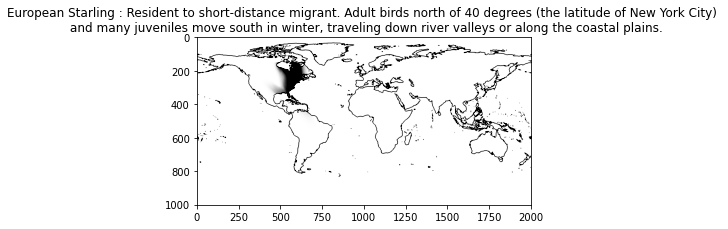

In [23]:
"""
Plots location predictions for a pair of classes.
"""

import torch
import numpy as np
import matplotlib.pyplot as plt
import json
import os

import sys
sys.path.append('../')
from geo_prior import models
from geo_prior.paths import get_paths
import geo_prior.datasets as dt
import geo_prior.grid_predictor as grid


# model_path = '../models/model_inat_2018_full_final.pth.tar'
# data_dir = get_paths('inat_2018_data_dir')
# op_dir = 'images/pair_ims/'
# if not os.path.isdir(op_dir):
#     os.makedirs(op_dir)

meta_data = '/scratch/sm9669/nabirds_with_loc_2019.json'


class_of_interest_1 = 400  # Bufo bufo - European toad
class_of_interest_2 = 500  # Bufo spinosus - Spiny toad
time_of_year = 0.5  # i.e. half way through the year

# load class names
with open(meta_data) as da:
    cls_data = json.load(da)
#class_names = [cc['name'] for cc in cls_data]
#class_ids = [cc['class_id'] for cc in cls_data]
#class_dict = dict(zip(class_ids, class_names))


print('Class of interest 1: ' + str(class_of_interest_1) )
print('Class of interest 2: ' + str(class_of_interest_2))


model_path = '/scratch/sm9669/nabird pickle/FCNET_30_.pth'
net_params = torch.load(model_path, map_location='cpu')
#params = net_params['params']
model = models.FCNet(num_inputs=6, num_classes=555,
                     num_filts=256, num_users=1).to(params['device'])

model.load_state_dict(net_params)
model.eval()


# load ocean mask
mask = np.load(get_paths('mask_dir') + 'ocean_mask.npy')


# grid predictor - for making dense predictions for each lon/lat location
gp = grid.GridPredictor(mask, params, mask_only_pred=True)


# make predictions for both classes
if not params['use_date_feats']:
    print('Trained model not using date features')

for i in range(0,11):
    grid_pred_1 = gp.dense_prediction(model, 400, time_step=8/10,mask_op=False)
    grid_pred_1 = grid_pred_1*gp.mask + gp.mask_lines 
    plt.close('all')
    plt.figure(0)
    plt.imshow(1-grid_pred_1, cmap='gray', vmin=0.5, vmax=1)
    description = 'European Starling : Resident to short-distance migrant. Adult birds north of 40 degrees (the latitude of New York City) \n and many juveniles move south in winter, traveling down river valleys or along the coastal plains.'
    plt.title( description)
    plt.show()
    break
